# Problem: Predicting Airplane Delays

The multi-fold goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model
- Move from a simple model to an ensemble model
- Hyperparameter optimization
- Check feature importance

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

## About this dataset
This dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1% of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2013 and 2018.

### Features
For more information about features in the dataset, see [On-time delay dataset features](https://www.transtats.bts.gov/Fields.asp).

### Dataset attributions  
Website: https://www.transtats.bts.gov/

Dataset(s) used in this lab were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available at https://www.transtats.bts.gov/DatabaseInfo.asp?DB_ID=120&DB_URL=Mode_ID=1&Mode_Desc=Aviation&Subject_ID2=0.

In [1]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Step 2: Data preprocessing and visualization

In [2]:
# Check whether the file is already in the desired path or if it needs to be downloaded

base_path = '/home/ec2-user/SageMaker/project/data/FlightDelays/'
csv_base_path = '/home/ec2-user/SageMaker/project/data/csvFlightDelays/'
file_path = 'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip'

if not os.path.isfile(base_path + file_path):
    subprocess.run(['mkdir', '-p', base_path])
    subprocess.run(['mkdir', '-p', csv_base_path])
    subprocess.run(['aws', 's3', 'cp', 
                    's3://aws-tc-largeobjects/ILT-TF-200-MLDWTS/flight_delay_project/csvFlightData-5/', 
                    base_path,'--recursive'])
else:
    print('File already downloaded!')

In [3]:
zip_files = [str(file) for file in list(Path(base_path).iterdir()) if '.zip' in str(file)]
len(zip_files)

60

#### Extract CSV files from ZIP files

In [4]:
def zip2csv(zipFile_name , file_path = '/home/ec2-user/SageMaker/project/data/csvFlightDelays'):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """
    try:
        with ZipFile(zipFile_name, 'r') as z: 
            print(f'Extracting {zipFile_name} ') 
            z.extractall(path=file_path) 
    except:
        print(f'zip2csv failed for {zipFile_name}')

for file in zip_files:
    zip2csv(file)

print("Files Extracted")

Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2015_4.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_2.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_7.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_8.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_6.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_5.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_10.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Tim

In [5]:
csv_files = [str(file) for file in list(Path(csv_base_path).iterdir()) if '.csv' in str(file)]
len(csv_files)

60

In [6]:
from IPython.display import IFrame, HTML

IFrame(src="./data/csvFlightDelays/readme.html", width=1000, height=600)

In [7]:
df_temp = pd.read_csv(f"{csv_base_path}On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv")

In [8]:
df_shape = df_temp.shape
print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is (585749, 110)


In [9]:
df_temp.head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018,3,9,16,7,2018-09-16,9E,20363,9E,N316PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018,3,9,17,1,2018-09-17,9E,20363,9E,N916XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018,3,9,20,4,2018-09-20,9E,20363,9E,N371CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018,3,9,21,5,2018-09-21,9E,20363,9E,N601LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018,3,9,23,7,2018-09-23,9E,20363,9E,N906XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [10]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

In [11]:
[col for col in df_temp.columns if 'Del' in col]

['DepDelay',
 'DepDelayMinutes',
 'DepDel15',
 'DepartureDelayGroups',
 'ArrDelay',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrivalDelayGroups',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'DivArrDelay']

In [12]:
print("The #rows and #columns are ", df_temp.shape[0] , " and ", df_temp.shape[1])
print("The years in this dataset are: ", list(df_temp.Year.unique()))
print("The months covered in this dataset are: ", sorted(list(df_temp.Month.unique())))
print("The date range for data is :" , min(df_temp.FlightDate), " to ", max(df_temp.FlightDate))
print("The airlines covered in this dataset are: ", list(df_temp.Reporting_Airline.unique()))
print("The Origin airports covered are: ", list(df_temp.Origin.unique()))
print("The Destination airports covered are: ", list(df_temp.Dest.unique()))

The #rows and #columns are  585749  and  110
The years in this dataset are:  [2018]
The months covered in this dataset are:  [9]
The date range for data is : 2018-09-01  to  2018-09-30
The airlines covered in this dataset are:  ['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO']
The Origin airports covered are:  ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE', 'SRQ

In [13]:
counts = pd.DataFrame({'Origin':df_temp['Origin'].value_counts(), 'Destination':df_temp['Dest'].value_counts()})
counts

,Origin,Destination
ABE,303,303
ABI,169,169
ABQ,2077,2076
ABR,60,60
ABY,79,79
ACK,129,129
ACT,135,135
ACV,122,122
ACY,242,242
ADK,9,9


In [14]:
counts.sort_values(by=['Origin'],ascending=False).head(15)

,Origin,Destination
ATL,31525,31521
ORD,28257,28250
DFW,22802,22795
DEN,19807,19807
CLT,19655,19654
LAX,17875,17873
SFO,14332,14348
IAH,14210,14203
LGA,13850,13850
MSP,13349,13347


In [15]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name = 'data/combined_files.csv'):
    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    """
    
    df = pd.DataFrame()
    
    for file in csv_files:
        df_temp = pd.read_csv(file)
        df_temp = df_temp[filter_cols]
        for col, val in zip(subset_cols,subset_vals):
            df_temp = df_temp[df_temp[col].isin(val)]      
        
        df = pd.concat([df, df_temp], axis=0)
    
        
    df.to_csv(file_name, index=False)
    print(f'Combined csv stored at {file_name}')

In [16]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

In [17]:
start = time.time()
combine_csv(csv_files, cols, subset_cols, subset_vals)
print(f'csv\'s merged in {round((time.time() - start)/60,2)} minutes')

Combined csv stored at data/combined_files.csv
csv's merged in 5.89 minutes


#### Load dataset


In [18]:
data = pd.read_csv('/home/ec2-user/SageMaker/project/data/combined_files.csv')

Print the first 5 records.

In [19]:
data.head(5)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,ArrDel15,AirTime
0,2018,4,10,14,7,2018-10-14,AA,LAX,CA,CLT,NC,1123,0.0,0.0,2125.0,9,-16.0,0.0,0.0,232.0
1,2018,4,10,15,1,2018-10-15,AA,LAX,CA,CLT,NC,1123,0.0,0.0,2125.0,9,-21.0,0.0,0.0,235.0
2,2018,4,10,16,2,2018-10-16,AA,LAX,CA,CLT,NC,1123,0.0,0.0,2125.0,9,-14.0,0.0,0.0,248.0
3,2018,4,10,17,3,2018-10-17,AA,LAX,CA,CLT,NC,1123,0.0,0.0,2125.0,9,-8.0,0.0,0.0,256.0
4,2018,4,10,18,4,2018-10-18,AA,LAX,CA,CLT,NC,1123,0.0,0.0,2125.0,9,-4.0,0.0,0.0,249.0


In [20]:
print("The #rows and #columns are ", data.shape[0] , " and ", data.shape[1])
print("The years in this dataset are: ", list(data.Year.unique()))
print("The months covered in this dataset are: ", sorted(list(data.Month.unique())))
print("The date range for data is :" , min(data.FlightDate), " to ", max(data.FlightDate))
print("The airlines covered in this dataset are: ", list(data.Reporting_Airline.unique()))
print("The Origin airports covered are: ", list(data.Origin.unique()))
print("The Destination airports covered are: ", list(data.Dest.unique()))

The #rows and #columns are  1658130  and  20
The years in this dataset are:  [2018, 2017, 2016, 2014, 2015]
The months covered in this dataset are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
The date range for data is : 2014-01-01  to  2018-12-31
The airlines covered in this dataset are:  ['AA', 'DL', 'UA', 'WN', 'OO']
The Origin airports covered are:  ['LAX', 'CLT', 'DEN', 'ATL', 'PHX', 'DFW', 'ORD', 'SFO', 'IAH']
The Destination airports covered are:  ['CLT', 'PHX', 'ORD', 'DEN', 'LAX', 'DFW', 'SFO', 'IAH', 'ATL']


In [21]:
# Rename ArrDel15 to is_delay
data.rename(columns={'ArrDel15':'is_delay'}, inplace=True) 

In [22]:
data.isnull().sum(axis = 0)

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
AirTime              22540
dtype: int64

In [23]:
### Remove null columns
data = data[~data.is_delay.isnull()]
data.isnull().sum(axis = 0)

Year                 0
Quarter              0
Month                0
DayofMonth           0
DayOfWeek            0
FlightDate           0
Reporting_Airline    0
Origin               0
OriginState          0
Dest                 0
DestState            0
CRSDepTime           0
Cancelled            0
Diverted             0
Distance             0
DistanceGroup        0
ArrDelay             0
ArrDelayMinutes      0
is_delay             0
AirTime              0
dtype: int64

Get the hour of the day in 24-hour time format from CRSDepTime.

In [24]:
data['DepHourofDay'] = (data['CRSDepTime']//100)

### Data exploration

#### Check class delay vs. no delay


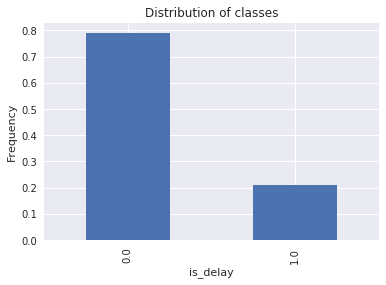

In [25]:
(data.groupby('is_delay').size()/len(data) ).plot(kind='bar')
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

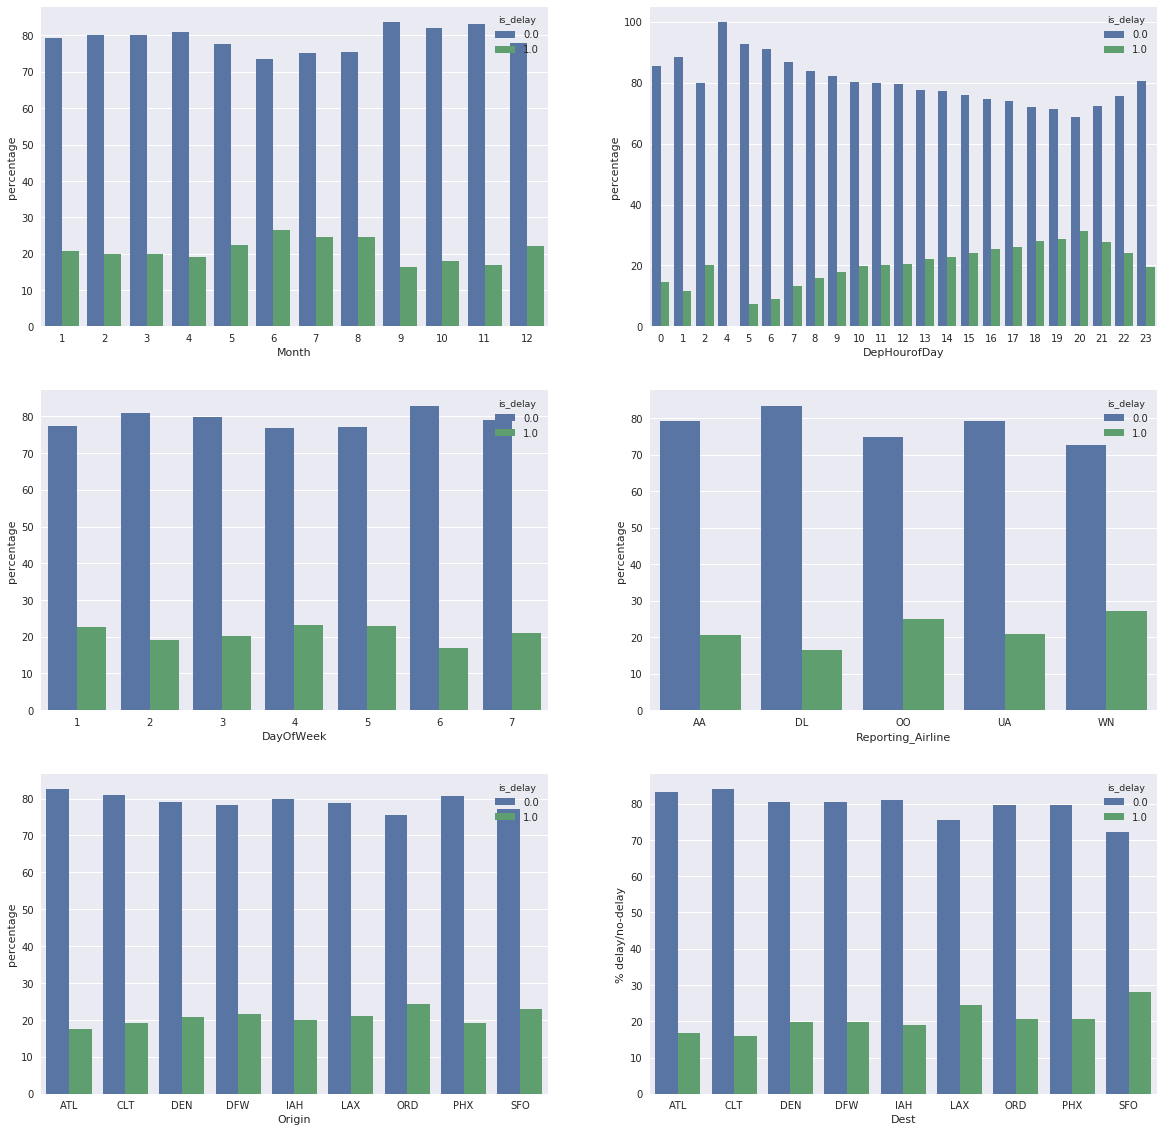

In [26]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

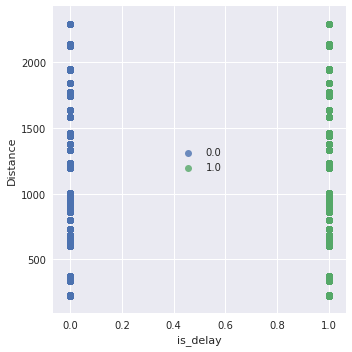

In [27]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

### Features

Look at all the columns and what their specific types are.

In [28]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

In [29]:
data_orig = data.copy()
data = data[[ 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay', 'is_delay']]
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay', 'is_delay']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [30]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)

Check the length of the dataset and the new columnms.

In [31]:
len(data)

1635590

In [32]:
data.columns

Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN',

In [33]:
data.rename(columns = {'is_delay':'target'}, inplace=True )

# Step 3: Model training and evaluation


### Train test split

In [34]:
from sklearn.model_selection import train_test_split

def create_training_sets(data):
    """
    Convert data frame to train, validation and test
    params:
        data: The dataframe with the dataset to be split
    Returns:
        train_features: Training feature dataset
        test_features: Test feature dataset 
        train_labels: Labels for the training dataset
        test_labels: Labels for the test dataset
        val_features: Validation feature dataset
        val_labels: Labels for the validation dataset
    """
    # Extract the target variable from the dataframe and convert the type to float32
    ys = np.array(data["target"]).astype("float32")
    
    # Drop all the unwanted columns including the target column
    drop_list = ["target"]
    
    # Drop the columns from the drop_list and convert the data into a NumPy array of type float32
    xs = np.array(data.drop(drop_list, axis=1)).astype("float32")
    
    np.random.seed(0)
    
    # Use the sklearn function train_test_split to split the dataset in the ratio train 80% and test 20%
    train_features, test_features, train_labels, test_labels = train_test_split(
    xs, ys, test_size=0.2)
    
    # Use the sklearn function again to split the temp dataset into 50% validation and 50% test
    val_features, test_features, val_labels, test_labels = train_test_split(
    test_features, test_labels, test_size=0.5)
    
    return train_features, test_features, train_labels, test_labels, val_features, val_labels

In [35]:
train_features, test_features, train_labels, test_labels, val_features, val_labels = create_training_sets(data)

print(f"Length of train_features is: {train_features.shape}")
print(f"Length of train_labels is: {train_labels.shape}")
print(f"Length of val_features is: {val_features.shape}")
print(f"Length of val_labels is: {val_labels.shape}")
print(f"Length of test_features is: {test_features.shape}")
print(f"Length of test_labels is: {test_labels.shape}")

Length of train_features is: (1308472, 94)
Length of train_labels is: (1308472,)
Length of val_features is: (163559, 94)
Length of val_labels is: (163559,)
Length of test_features is: (163559, 94)
Length of test_labels is: (163559,)


### Baseline classification model

In [36]:
import sagemaker
from sagemaker.predictor import csv_serializer
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

# Instantiate the LinearLearner estimator object
num_classes = len(pd.unique(train_labels)) 

classifier_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               train_instance_count=1,
                                               train_instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier',
                                              binary_classifier_model_selection_criteria = 'cross_entropy_loss')

In [37]:
### Create train, val, test records
train_records = classifier_estimator.record_set(train_features, train_labels, channel='train')
val_records = classifier_estimator.record_set(val_features, val_labels, channel='validation')
test_records = classifier_estimator.record_set(test_features, test_labels, channel='test')

### Fit the classifier
classifier_estimator.fit([train_records, val_records, test_records])

2020-04-27 19:51:42 Starting - Starting the training job...
2020-04-27 19:51:43 Starting - Launching requested ML instances......
2020-04-27 19:52:44 Starting - Preparing the instances for training......
2020-04-27 19:53:53 Downloading - Downloading input data...
2020-04-27 19:54:33 Training - Downloading the training image..
2020-04-27 19:54:53 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/27/2020 19:54:56 INFO 140156964878144] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u

## Model evaluation

In [38]:
### Deloy an endpoint for batch prediction
classifier_predictor = classifier_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------!

In [39]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

def predict_batches(predictor, features, labels):
    """
    Return evaluation results
    predictor : Predictor object of model
    features: Input features to model
    label: Ground truth target values
    """
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(features, 100)]

    # Parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label['predicted_label'].float32_tensor.values
    preds = np.concatenate([np.array([extract_label(x) for x in batch]) for batch in prediction_batches])
    preds = preds.reshape((-1,))

    # Calculate accuracy
    accuracy = (preds == labels).sum() / labels.shape[0]
    print(f'Accuracy: {accuracy}')
    
    auc = roc_auc_score(labels, preds)
    print(f'AUC     : {auc}')
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, preds, average = 'binary')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1_score: {f1_score}')
    
    confusion_matrix = pd.crosstab(index=labels, columns=np.round(preds), rownames=['True'], colnames=['predictions']).astype(int)
    plt.figure(figsize = (5,5))
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix') 

# Step 4: Feature engineering

#### Add more features

1. Holidays
2. Weather

In [1]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
# holidays_19 = ['2019-01-01', '2019-01-21', '2019-02-18', '2019-05-27' , '2019-07-04', '2019-09-02' ,'2019-10-14', '2019-11-11','2019-11-28', '2019-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = data_orig.FlightDate.isin(holidays).astype(int)

NameError: name 'data_orig' is not defined

In [42]:
%%bash
aws s3 cp s3://aws-tc-largeobjects/ILT-TF-200-MLDWTS/flight_delay_project/daily-summaries.csv /home/ec2-user/SageMaker/project/data/
#wget 'https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31' -O /home/ec2-user/SageMaker/project/data/daily-summaries.csv

download: s3://aws-tc-largeobjects/ILT-TF-200-MLDWTS/flight_delay_project/daily-summaries.csv to data/daily-summaries.csv


In [43]:
weather = pd.read_csv('/home/ec2-user/SageMaker/project/data/daily-summaries.csv')
station = ['USW00023174','USW00012960','USW00003017','USW00094846','USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = {s:a for s,a in zip(station, airports)}
weather['airport'] = weather['STATION'].map(station_map)

In [44]:
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1])
weather.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX,01
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX,01
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX,01
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0,LAX,01
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0,LAX,01


In [45]:
weather.SNOW.fillna(0, inplace=True)
weather.SNWD.fillna(0, inplace=True)
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

In [46]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = idx[weather.TAVG.isna()]
TMAX_idx = idx[weather.TMAX.isna()]
TMIN_idx = idx[weather.TMIN.isna()]
TAVG_idx

array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])

In [47]:
weather_impute = weather.groupby(['MONTH','STATION']).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()
weather_impute.head(2)

,MONTH,STATION,TAVG,TMAX,TMIN
0,01,USW00003017,-2.741935,74.000000,-69.858065
1,01,USW00003927,79.529032,143.767742,20.696774


In [48]:
weather.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH
0,USW00023174,2014-01-01,16,0,0.0,0.0,131.0,178.0,78.0,LAX,01
1,USW00023174,2014-01-02,22,0,0.0,0.0,159.0,256.0,100.0,LAX,01
2,USW00023174,2014-01-03,17,0,0.0,0.0,140.0,178.0,83.0,LAX,01
3,USW00023174,2014-01-04,18,0,0.0,0.0,136.0,183.0,100.0,LAX,01
4,USW00023174,2014-01-05,18,0,0.0,0.0,151.0,244.0,83.0,LAX,01


In [49]:
weather_impute

,MONTH,STATION,TAVG,TMAX,TMIN
0,01,USW00003017,-2.741935,74.000000,-69.858065
1,01,USW00003927,79.529032,143.767742,20.696774
2,01,USW00012960,110.535484,170.438710,52.425806
3,01,USW00013874,59.070968,114.600000,8.161290
4,01,USW00013881,48.929032,106.529032,-15.645161
5,01,USW00023174,148.619355,198.154839,103.477419
6,01,USW00023183,142.270968,207.341935,82.406452
7,01,USW00023234,115.400000,152.580645,82.490323
8,01,USW00094846,-46.929032,-8.612903,-87.690323
9,02,USW00003017,11.219858,88.553191,-65.035461


In [50]:
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

In [51]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

In [52]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

In [53]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

In [54]:
sum(data.isna().any())

0

In [55]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay',
       'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'SNOW_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data using one-hot encoding.

In [56]:
data = data_orig.copy()
data = data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay', 'is_delay', 'is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 
                        'DayOfWeek', 'Reporting_Airline', 'Origin', 
                        'Dest', 'is_holiday','is_delay']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [57]:
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 
                                    'DayofMonth', 'DayOfWeek', 
                                    'Reporting_Airline', 'Origin', 
                                    'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)

Check the new columns.

In [58]:
data.columns

Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayO

In [59]:
data.rename(columns = {'is_delay':'target'}, inplace=True )

Create the training sets again.

In [60]:
train_features, test_features, train_labels, test_labels, val_features, val_labels = create_training_sets(data)

print(f"Length of train_features is: {train_features.shape}")
print(f"Length of train_labels is: {train_labels.shape}")
print(f"Length of val_features is: {val_features.shape}")
print(f"Length of val_labels is: {val_labels.shape}")
print(f"Length of test_features is: {test_features.shape}")
print(f"Length of test_labels is: {test_labels.shape}")

Length of train_features is: (1308472, 85)
Length of train_labels is: (1308472,)
Length of val_features is: (163559, 85)
Length of val_labels is: (163559,)
Length of test_features is: (163559, 85)
Length of test_labels is: (163559,)


### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [61]:
# Instantiate the LinearLearner estimator object
num_classes = len(pd.unique(train_labels)) 
classifier_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               train_instance_count=1,
                                               train_instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier',
                                              binary_classifier_model_selection_criteria = 'cross_entropy_loss')

In [62]:
train_records = classifier_estimator.record_set(train_features, train_labels, channel='train')
val_records = classifier_estimator.record_set(val_features, val_labels, channel='validation')
test_records = classifier_estimator.record_set(test_features, test_labels, channel='test')

classifier_estimator.fit([train_records, val_records, test_records])

2020-04-27 20:08:54 Starting - Starting the training job...
2020-04-27 20:08:55 Starting - Launching requested ML instances......
2020-04-27 20:09:55 Starting - Preparing the instances for training...
2020-04-27 20:10:49 Downloading - Downloading input data......
2020-04-27 20:11:50 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/27/2020 20:11:52 INFO 139637970978624] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_

In [63]:
classifier_predictor = classifier_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------!

Accuracy: 0.7934995934188886
AUC     : 0.5227056001797192
Precision: 0.5544916924809913
Recall: 0.057637140682629824
F1_score: 0.10442022644711373


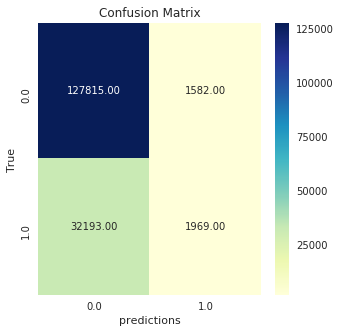

In [64]:
predict_batches(classifier_predictor, test_features, test_labels)

The linear model shows only a little improvement in performance. Try a tree-based ensemble model called XGBoost with Amazon SageMaker.

### Try the XGBoost model

In [65]:
train_data, validation_data, test_data = np.split(data.sample(frac=1, random_state=1729), [int(0.7 * len(data)), int(0.9*len(data))])  

pd.concat([train_data['target'], train_data.drop(['target'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['target'], validation_data.drop(['target'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)
pd.concat([test_data['target'], test_data.drop(['target'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)

In [66]:
bucket = 'ml-pipeline-bucket'
prefix = 'sagemaker/xgboost'

In [67]:
### Upload data to S3
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [68]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')

In [69]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [70]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role = sagemaker.get_execution_role(), 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric = "auc", 
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-04-27 20:24:49 Starting - Starting the training job...
2020-04-27 20:24:51 Starting - Launching requested ML instances......
2020-04-27 20:25:51 Starting - Preparing the instances for training...
2020-04-27 20:26:38 Downloading - Downloading input data...
2020-04-27 20:26:56 Training - Downloading the training image...
2020-04-27 20:27:30 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO

Deploy the predictor for your new model and evaluate the model on the test dataset.

In [71]:
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

-------------!

In [72]:
test_data = pd.concat([test_data['target'], test_data.drop(['target'], axis=1)], axis=1)

In [73]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None


def predict(predictor , features, labels , prob_threshold = 0.5, rows=500):
    """
    Return evaluation results
    predictor : Predictor object of model
    features: Input features to model
    label: Ground truth target values
    prob_threshold : Probability cut off to separate positive and negative class
    """
    split_array = np.array_split(features, int(features.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    preds = np.fromstring(predictions[1:], sep=',')
    preds = preds.reshape((-1,))
    predictions = np.where(preds > prob_threshold , 1, 0)
    labels = labels.reshape((-1,))
    
    
    # Calculate accuracy
    accuracy = (predictions == labels).sum() / labels.shape[0]
    print(f'Accuracy: {accuracy}')
    
    auc = roc_auc_score(labels, preds)
    print(f'AUC     : {auc}')
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, predictions, average = 'binary')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1_score: {f1_score}')
    
    
    confusion_matrix = pd.crosstab(index=labels, columns=np.round(preds), rownames=['True'], colnames=['predictions']).astype(int)
    plt.figure(figsize = (5,5))
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix') 
    return list(preds)

Accuracy: 0.8064184789586633
AUC     : 0.7281063559323709
Precision: 0.661878453038674
Recall: 0.14091630888666706
F1_score: 0.23236192600494593


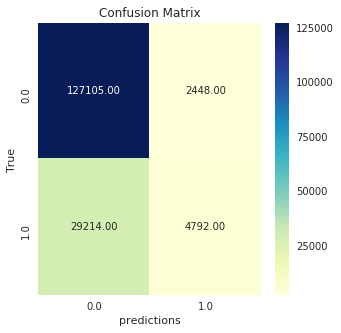

In [74]:
predictions = predict(xgb_predictor, test_data.as_matrix()[:, 1:] ,  test_data.iloc[:, 0:1].as_matrix(), prob_threshold = 0.5)

### Hyperparameter optimization (HPO)

In [76]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

### You can spin up multiple instances to do hyperparameter optimization in parallel

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    train_instance_count= 2, # make sure you have limit set for these instances
                                    train_instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='auc',
                        objective='binary:logistic',
                        num_round=100,
                        rate_drop=0.3,
                        tweedie_variance_power=1.4)

In [77]:
hyperparameter_ranges = {'eta': ContinuousParameter(0, 0.5),
                        'min_child_weight': ContinuousParameter(3, 10),
                         'num_round': IntegerParameter(10, 150),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(10, 15)}

objective_metric_name = 'validation:auc'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10,
                            max_parallel_jobs=3)

In [78]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [79]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'InProgress'

In [85]:
sage_client = boto3.Session().client('sagemaker')
tuning_job_name = tuner.latest_tuning_job.job_name

# Run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']


from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")
    
### Get the hyperparameter tuning job results in a dataframe
tuner_df = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name).dataframe()

if len(tuner_df) > 0:
    df = tuner_df[tuner_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
tuner_df

Reminder: the tuning job has not been completed.
6 training jobs have completed
Best model found so far:
{'CreationTime': datetime.datetime(2020, 4, 27, 20, 38, 49, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.7692300081253052},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2020, 4, 27, 21, 14, 24, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-west-2:949819685253:training-job/sagemaker-xgboost-200427-2038-002-81e349c1',
 'TrainingJobName': 'sagemaker-xgboost-200427-2038-002-81e349c1',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2020, 4, 27, 20, 41, 45, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '0.024139240296463527',
                          'eta': '0.21256251343825672',
                          'max_depth': '13',
                          'min_child_weight': '8.098219252732404',
          

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,alpha,eta,max_depth,min_child_weight,num_round
0,NaN,NaN,NaT,sagemaker-xgboost-200427-2038-009-901f1ffc,InProgress,2020-04-27 21:31:43+00:00,1.069870,0.497441,13.0,3.000000,77.0
1,NaN,NaN,NaT,sagemaker-xgboost-200427-2038-008-f9cc919a,InProgress,2020-04-27 21:31:13+00:00,0.740891,0.486058,15.0,6.174007,146.0
2,NaN,NaN,NaT,sagemaker-xgboost-200427-2038-007-1f59e167,InProgress,2020-04-27 21:22:22+00:00,0.298813,0.000000,15.0,4.809597,136.0
3,0.500000,661.0,2020-04-27 21:28:26+00:00,sagemaker-xgboost-200427-2038-006-3ce24d46,Completed,2020-04-27 21:17:25+00:00,0.556726,0.000000,11.0,7.332989,47.0
4,0.764144,676.0,2020-04-27 21:19:45+00:00,sagemaker-xgboost-200427-2038-005-99a1d3be,Completed,2020-04-27 21:08:29+00:00,1.179428,0.253844,15.0,3.162990,33.0
5,0.762943,1319.0,2020-04-27 21:28:30+00:00,sagemaker-xgboost-200427-2038-004-554b90e7,Completed,2020-04-27 21:06:31+00:00,0.352868,0.338688,15.0,9.634137,77.0
6,0.768069,1507.0,2020-04-27 21:06:00+00:00,sagemaker-xgboost-200427-2038-003-756734b0,Completed,2020-04-27 20:40:53+00:00,0.126211,0.288747,12.0,9.782580,115.0
7,0.769230,1959.0,2020-04-27 21:14:24+00:00,sagemaker-xgboost-200427-2038-002-81e349c1,Completed,2020-04-27 20:41:45+00:00,0.024139,0.212563,13.0,8.098219,135.0
8,0.768995,1153.0,2020-04-27 21:00:11+00:00,sagemaker-xgboost-200427-2038-001-1c27d660,Completed,2020-04-27 20:40:58+00:00,1.170964,0.210214,14.0,3.655323,70.0


Deploy the best model from the hyperparameter optimization training.

In [86]:
xgb_predictor_hpo = tuner.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

2020-04-27 21:14:24 Starting - Preparing the instances for training
2020-04-27 21:14:24 Downloading - Downloading input data
2020-04-27 21:14:24 Training - Training image download completed. Training in progress.
2020-04-27 21:14:24 Uploading - Uploading generated training model
2020-04-27 21:14:24 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is

Accuracy: 0.8234704296308977
AUC     : 0.7698705637059648
Precision: 0.667362243234431
Recall: 0.30094689172498973
F1_score: 0.4148274254676638


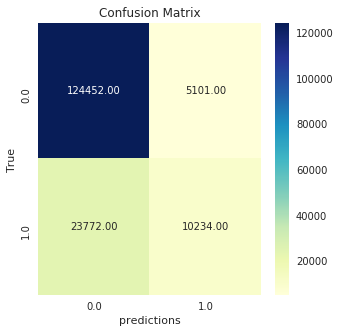

In [87]:
xgb_predictor_hpo.content_type = 'text/csv'
xgb_predictor_hpo.serializer = csv_serializer
xgb_predictor_hpo.deserializer = None

predictions = predict(xgb_predictor_hpo, test_data.as_matrix()[:, 1:] ,  test_data.iloc[:, 0:1].as_matrix(), prob_threshold = 0.5)

### Feature importance

In [88]:
# best_hpo_model_path = "s3://" + bucket + "/sagemaker/xgboost/output/<Best model TrainingJobName>/output/model.tar.gz"
best_hpo_model_path = "s3://" + bucket + "/sagemaker/xgboost/output/sagemaker-xgboost-200427-2038-002-81e349c1/output/model.tar.gz"
### Download best_hpo_model_path to local
!aws s3 cp {best_hpo_model_path} .

download: s3://ml-pipeline-bucket/sagemaker/xgboost/output/sagemaker-xgboost-200427-2038-002-81e349c1/output/model.tar.gz to ./model.tar.gz


In [89]:
!pip install xgboost=='0.90'

    100% |████████████████████████████████| 142.8MB 358kB/s eta 0:00:01   32% |██████████▌                     | 47.0MB 74.5MB/s eta 0:00:02
You are using pip version 10.0.1, however version 20.1b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#### Load picked model file

In [90]:
import pickle
import tarfile
import xgboost

with open('model.tar.gz', 'rb') as f:
    with tarfile.open(fileobj=f, mode='r') as tar_f:
        with tar_f.extractfile('xgboost-model') as extracted_f:
            xgbooster = pickle.load(extracted_f)

#### Map column names to XGBoost model

In [91]:
columns = list(data.columns)
columns.remove('target')

In [92]:
feature_importance = xgbooster.get_fscore()
feature_importance_col = {}

for column, fname in zip(columns, xgbooster.feature_names):
    try:
         feature_importance_col[column] = feature_importance[fname]
    except Exception:
        pass

#### Sort by feature importance value

In [93]:
sorted(feature_importance_col.items(), key=lambda kv: kv[1], reverse=True)

[('DepHourofDay', 24932),
 ('AWND_D', 20735),
 ('AWND_O', 20641),
 ('TAVG_O', 19883),
 ('TAVG_D', 19378),
 ('Distance', 14298),
 ('PRCP_O', 6585),
 ('PRCP_D', 6549),
 ('Reporting_Airline_UA', 3229),
 ('Year_2018', 1894),
 ('Year_2016', 1850),
 ('Year_2015', 1800),
 ('Year_2017', 1762),
 ('Reporting_Airline_WN', 1461),
 ('Reporting_Airline_DL', 1454),
 ('Quarter_4', 1418),
 ('DayOfWeek_4', 1263),
 ('DayOfWeek_5', 1194),
 ('DayOfWeek_7', 1134),
 ('Quarter_2', 1112),
 ('DayOfWeek_3', 1111),
 ('Reporting_Airline_OO', 1079),
 ('DayOfWeek_2', 994),
 ('DayOfWeek_6', 935),
 ('Month_7', 930),
 ('Origin_ORD', 929),
 ('Dest_LAX', 923),
 ('Origin_LAX', 904),
 ('Dest_ORD', 872),
 ('Month_8', 855),
 ('SNOW_O', 837),
 ('Month_3', 837),
 ('Month_12', 801),
 ('Month_2', 799),
 ('Dest_DFW', 792),
 ('Origin_DFW', 779),
 ('Dest_DEN', 754),
 ('Month_5', 736),
 ('Origin_DEN', 727),
 ('Month_11', 724),
 ('Dest_SFO', 717),
 ('SNOW_D', 698),
 ('Origin_IAH', 681),
 ('Month_9', 643),
 ('Month_10', 642),
 ('Month